In [1]:
import pandas as pd
import geopandas as gpd
import pathlib
import numpy as np
import geojson

import matplotlib.pyplot as plt

import dtv_backend.climate
import dtv_backend.fis

/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Waterlevels as function of river discharge
This notebook determines the waterlevels as a function of river discharge for the Dutch rivers. These are based on the betrekkingslijnen, the Q-h relationship.  The data are stored on "km marks", markings each km along the fairway. 

We follow the following steps:
- Download information about markings in the river
- Open and read the xls file containing information of the Q-h relationship
- Do a spatial join between the two datasets
- Define interpolation functions over Q and over space. 


In [2]:
# general settings, the data where information is stored
data_dir = pathlib.Path('~/data/river/dtv/betrekkingslijnen')
download = False

epsg_utm31n = 32631
epsg_wgs84 = 4326
epsg_rd = 28992

value_column = "waterlevel"



### Download 
Here we get extra information on the fairway from Rijkswaterstaat. We also need to connect it to the Fairway Information System. 

In [3]:
if download:
    !wget -c -q -O {data_dir / 'kmmarkeringen.geojson' } 'https://geodata.nationaalgeoregister.nl/nwbvaarwegen/wfs?request=GetFeature&service=WFS&version=2.0.0&outputFormat=json&typeNames=nwbvaarwegen:kmmarkeringen'
    !wget -c -q -O {data_dir / 'vaarwegvakken.geojson' } 'https://geodata.nationaalgeoregister.nl/nwbvaarwegen/wfs?request=GetFeature&service=WFS&version=1.1.0&outputFormat=json&typeName=vaarwegvakken'

kmmarkering_path = data_dir / 'kmmarkeringen.geojson'
vaarwegvakken_path = data_dir / 'vaarwegvakken.geojson'


### Read xls 
Here we read the waterlevels that are a function of the Lobith discharge (Q).  These are stored in separate sheets.

In [4]:
# betrekkingslijnen (From Remi)
betrekkingslijnen_lobith_path = data_dir / 'Betrekkingslijnen2018' / 'Betrekkingslijnen_2018_h-Lobith_650-1780_rkm.xlsx'
betrekkingslijnen_maas_path = data_dir / 'KenmerkendeWaardenMaas' / 'betrekkingslijnen_maas_2019_2020.xlsx'


# Excel sheet names with corresponding vaarwegvakken names
sheet_names = {
    "Bovenrijn-Waal": "Boven-Rijn|Waal",
    "Pkan-NRijn-Lek": "Pannerdensch Kanaal|Neder-Rijn|Lek",
    "IJssel": "IJssel"
}


name_vaarweg_codes = {
    "Bovenrijn-Waal": "101",
    "IJssel": "084",
    "Pkan-NRijn-Lek": "103"
}

In [5]:
# Read betrekingslijnen  NOTE: usecols is hardcoded!
lobith_df = pd.read_excel(betrekkingslijnen_lobith_path, sheet_name=list(sheet_names.keys()), skiprows=[0, 1, 3, 4, 5], header=0, usecols="B:DL", index_col=0)
lobith_df['Bovenrijn-Waal'].head()

,703.30,738.98,774.78,810.84,847.19,883.69,919.63,958.35,999.80,1040.45,...,13046.74,13366.10,13691.69,14023.47,14361.35,14705.30,15055.23,15411.12,15772.93,16140.64
854.0,7.93,7.99,8.06,8.13,8.21,8.29,8.39,8.48,8.57,8.66,...,18.61,18.74,18.87,19.01,19.14,19.28,19.41,19.55,19.69,19.84
855.0,7.71,7.78,7.85,7.93,8.01,8.10,8.19,8.28,8.37,8.47,...,18.36,18.48,18.61,18.74,18.87,19.00,19.12,19.25,19.39,19.53
856.0,7.43,7.51,7.58,7.67,7.75,7.84,7.93,8.03,8.12,8.22,...,18.20,18.32,18.45,18.58,18.70,18.83,18.95,19.08,19.21,19.35
857.0,7.21,7.29,7.37,7.46,7.55,7.64,7.76,7.86,7.95,8.05,...,18.04,18.16,18.28,18.41,18.53,18.65,18.78,18.90,19.03,19.16
858.0,7.04,7.13,7.22,7.31,7.40,7.49,7.62,7.71,7.81,7.91,...,17.77,17.89,18.01,18.13,18.25,18.37,18.50,18.62,18.74,18.86


In [6]:
# Read betrekingslijnen  NOTE: usecols and skip rows are hardcoded!
maas_df = pd.read_excel(betrekkingslijnen_maas_path, skiprows=[0, 1, 2, 3, 5, 6, 7], usecols="C:T", index_col=0)
# some strange empty rows, get rid of them
maas_df = maas_df.dropna()
maas_df = maas_df.astype(float)

### Data wrangling
Now we have to reorganize the data a bit before we can do a spatial join. We need an integer kilometer mark

In [7]:
# Column: Discharge Lobith [m3/s]
# Row: Kilometermarkering
# Cell: ws -> waterstand [m+NAP]

 # (name='km-markering')

river_dfs = []
for sheet_name in sheet_names:
    river_df = lobith_df[sheet_name]
    river_with_km = river_df.reset_index().rename(columns={'index': 'km_markering'})
    river_flat = river_with_km.melt(id_vars=['km_markering'], value_name='waterlevel')
    river_flat = river_flat.rename(columns={'variable': 'discharge'})
    river_flat['discharge'] = river_flat['discharge'].astype(float)

    river_flat['river'] = sheet_name
    river_flat['vrt_code'] = name_vaarweg_codes[sheet_name]
    river_flat['discharge_location'] = 'Lobith'
    river_dfs.append(river_flat)

# add the Maas   
river_with_km = maas_df.reset_index().rename(columns={'index': 'km_markering'})
river_flat = river_with_km.melt(id_vars=['km_markering'], value_name='waterlevel')
river_flat = river_flat.rename(columns={'variable': 'discharge'})
# fix the data type to float
river_flat['discharge'] = river_flat['discharge'].astype(float)
river_flat['river'] = 'Maas'
# add the discharge location
river_flat['discharge_location'] = 'st Pieter'
# manual lookup
river_flat['vrt_code'] = '150'
river_dfs.append(river_flat)

river_df = pd.concat(river_dfs)
river_df = river_df.dropna()

# 31 locations are not integer locations,  discuss with Remi
# river_df[~np.isclose(river_df['km_markering'] % 1, 0)].groupby('km_markering').first()

# Floor the markings for geolocating
river_df['km_markering_int'] = np.floor(river_df['km_markering']).astype('int')
river_df.head()



,km_markering,discharge,waterlevel,river,vrt_code,discharge_location,km_markering_int
0,854.0,703.3,7.93,Bovenrijn-Waal,101,Lobith,854
1,855.0,703.3,7.71,Bovenrijn-Waal,101,Lobith,855
2,856.0,703.3,7.43,Bovenrijn-Waal,101,Lobith,856
3,857.0,703.3,7.21,Bovenrijn-Waal,101,Lobith,857
4,858.0,703.3,7.04,Bovenrijn-Waal,101,Lobith,858


### Spatial join
Now we connect the kilometer markings with the data. This way we can geolocate the waterlevels on points on the river.


<AxesSubplot:>

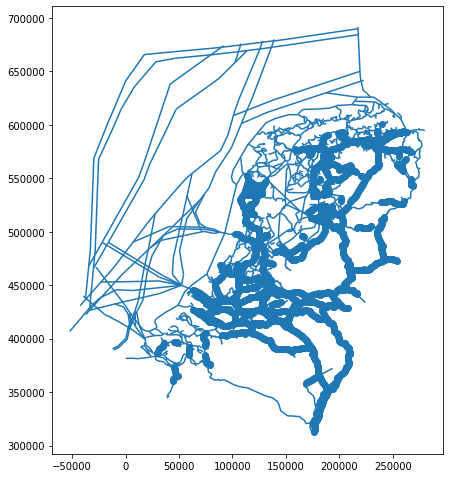

In [8]:
kmm_gdf = gpd.read_file(kmmarkering_path, crs=epsg_rd)
vwv_gdf = gpd.read_file(vaarwegvakken_path, crs=epsg_rd)

fig, ax = plt.subplots(figsize=(7, 13))
kmm_gdf.plot(ax=ax)
vwv_gdf.plot(ax=ax)


In [9]:
# we'll store everything here...
river_with_discharges = []
# this is a bit complex

# First we organize the data bij "vaarroute"
# each vaarrroute has a code
# For example the Boven-Rijn, Waal, Boven-Merwede has code '101' (string, not integer)
# https://www.vaarweginformatie.nl/frp/main/#/geo/detail/ROUTE/46733
for vrt_code in set(river_df.vrt_code):
    # distances are relative within a vaarroute so we can connect to kilometer marks if we are within the same vaarroute
    idx = vwv_gdf.vrt_code  == vrt_code
    
    # the vaarrroute are not in the same file as the markings
    # now we can determine the vaarwegvakken
    vwk_ids = vwv_gdf[idx].vwk_id
    
    # with the vaarwegvakken we can select relevant kilometerpalen entries using the vakken ids
    kmm_gdf_idx = kmm_gdf.vwk_id.isin(vwk_ids)
    
    # make a copy so we can alter it
    kmm_gdf_selected = kmm_gdf[kmm_gdf_idx].copy()
    
    # add integer version
    # the actual kilometer marking is stored in the "getalwaarde" gtlwaarde (number value) of the table
    # it only has integers, cast to integer for coupling
    kmm_gdf_selected['km_markering_int'] = np.floor(kmm_gdf_selected['gtlwaarde']).astype('int')
    
    # now we can select the part of our data that we can join
    river_df_selected = river_df[river_df.vrt_code == vrt_code]
    # do an inner join for the subsets
    river_with_discharge = pd.merge(kmm_gdf_selected, river_df_selected, left_on='km_markering_int', right_on='km_markering_int')
    # store in the table 
    river_with_discharges.append(river_with_discharge)

# this is the result
river_with_discharges_gdf = pd.concat(river_with_discharges)




# reproject
river_with_discharges_gdf = river_with_discharges_gdf.to_crs(epsg_wgs84)
# now we have a flat table with all the info we want
river_with_discharges_gdf.head()



,id,vwk_id,vwk_begindatum,pos_tov_as,gtlwaarde,ltrwaarde,afstand,mst_code,geometry,km_markering_int,km_markering,discharge,waterlevel,river,vrt_code,discharge_location
0,kmmarkeringen.15,2595,2003-04-30,R,13.0,None,10320,O,POINT (5.75252 50.97127),13,13.0,80.0,44.12,Maas,150,st Pieter
1,kmmarkeringen.15,2595,2003-04-30,R,13.0,None,10320,O,POINT (5.75252 50.97127),13,13.0,155.0,44.12,Maas,150,st Pieter
2,kmmarkeringen.15,2595,2003-04-30,R,13.0,None,10320,O,POINT (5.75252 50.97127),13,13.0,280.0,44.13,Maas,150,st Pieter
3,kmmarkeringen.15,2595,2003-04-30,R,13.0,None,10320,O,POINT (5.75252 50.97127),13,13.0,530.0,44.18,Maas,150,st Pieter
4,kmmarkeringen.15,2595,2003-04-30,R,13.0,None,10320,O,POINT (5.75252 50.97127),13,13.0,1030.0,44.44,Maas,150,st Pieter


In [12]:
river_with_discharges_gdf.to_file(f'../../dtv_backend/data/river_{value_column}.geojson')

river_interpolator_gdf = dtv_backend.climate.create_river_interpolator_gdf(river_with_discharges_gdf)
river_interpolator_gdf.to_pickle(f'../../dtv_backend/data/river_{value_column}_interpolator_gdf.pickle')


/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### Service implementation
This part shows how to use the river_with_discharges geojson in a service.

In [13]:
# our input
climate = {
    "discharge_lobith": 1000,
    "discharge_st_pieter": 300
}

river_with_discharges_gdf = dtv_backend.climate.get_river_with_discharges_gdf(value_column=value_column)

<AxesSubplot:>

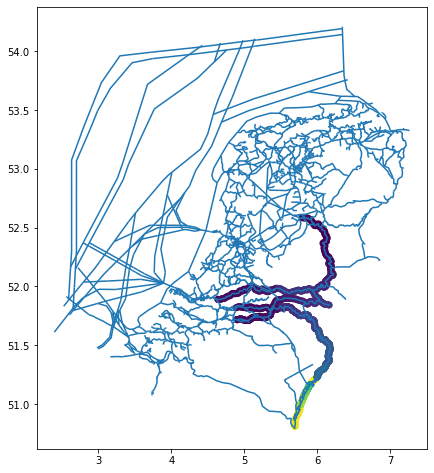

In [14]:
# the lowest diarchge scenario is 703.3, select it and plot the waterlevels
fig, ax = plt.subplots(figsize=(7, 13))
vwv_gdf.to_crs(epsg_wgs84).plot(ax=ax)
river_with_discharges_gdf.query('discharge < 705').plot(value_column, ax=ax)

### Interpolation over Q

In [15]:
river_interpolator_gdf = dtv_backend.climate.get_river_interpolator_gdf(value_column=value_column)


Text(0, 0.5, 'waterlevel [m w.r.t NAP] ')

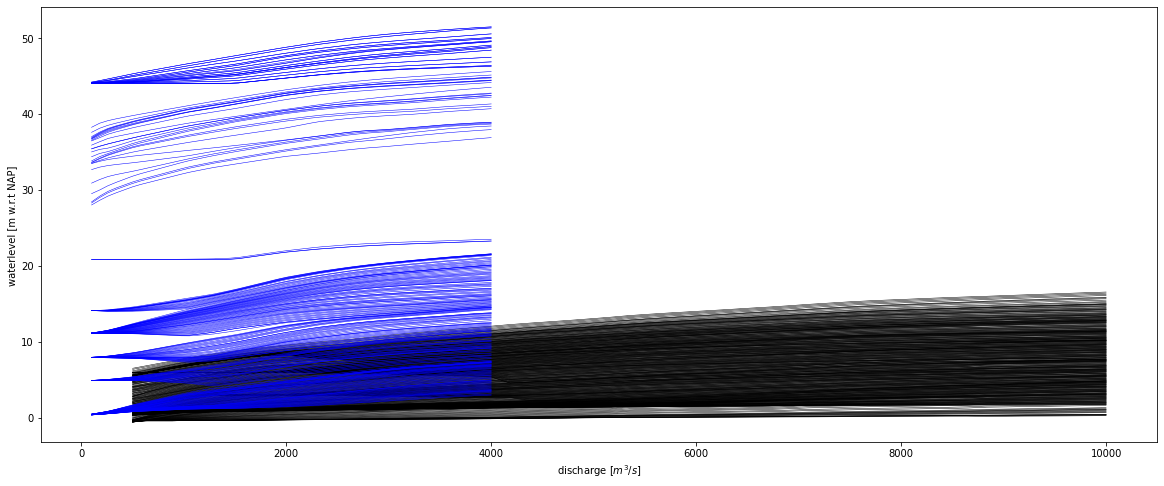

In [16]:
# plot at one location
fig, ax = plt.subplots(figsize=(20, 8))
discharge = np.linspace(500, 10000)
waterlevel = river_interpolator_gdf.query('discharge_location == "Lobith"')['interpolate'].apply(lambda x: pd.Series(x(discharge)))
ax.plot(discharge, waterlevel.values.T, 'k-', alpha=1, linewidth=0.5);
discharge = np.linspace(100, 4000)
waterlevel = river_interpolator_gdf.query('discharge_location == "st Pieter"')['interpolate'].apply(lambda x: pd.Series(x(discharge)))
ax.plot(discharge, waterlevel.values.T, 'b-', alpha=1, linewidth=0.5);
ax.set_xlabel('discharge [$m^3/s$]')
ax.set_ylabel('waterlevel [m w.r.t NAP] ')
# ax.set_ylim(0, 50)

### Interpolation over space

In [17]:
import networkx as nx
import shapely.geometry

FG = nx.read_gpickle('../fis-network/result/network_digital_twin_v0.3.pickle')
for n, node in FG.nodes.items():
    node['geometry'] = shapely.geometry.shape(node['geometry'])
for e, edge in FG.edges.items():
    edge['geometry'] = shapely.geometry.shape(edge['geometry'])


In [19]:


def waterlevels(climate):
    result = dtv_backend.climate.interpolated_values_for_climate(
        climate=climate, graph=FG, river_interpolator_gdf=river_interpolator_gdf, epsg=epsg_utm31n)
    response = result._to_geo()
    return response

%timeit resp = waterlevels(climate)


/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


84.8 ms ± 1.62 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<AxesSubplot:>

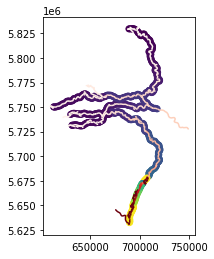

In [22]:
fig, ax = plt.subplots()
dtv_backend.climate.value_for_climate(river_interpolator_gdf=river_interpolator_gdf, climate=climate, value_column=value_column).to_crs(epsg_utm31n).plot('waterlevel', ax=ax)
dtv_backend.climate.interpolated_values_for_climate(climate=climate, graph=FG, river_interpolator_gdf=river_interpolator_gdf, value_column=value_column).plot('waterlevel', ax=ax, cmap='Reds')
